# AI 07a CIFAR-10 (Kaggle)



---

![alt text](https://ycs-class.s3.ap-northeast-2.amazonaws.com/images/cifar10.png)

YCS1003-02 CIFAR-10 Competition 2020-2


CIFAR-10은 32x32픽셀의 컬러이미지(RGB) 60000개로 이루어져 있으며

( training set - 50000, test set - 10000 )

각 이미지는 10개의 클래스로 구분되어있습니다.



주어진 SimpleCNN 모델의 구조와 하이퍼파라미터를 변경하며 성능을 향상시켜보고

CIFAR-10 dataset에 대한 예측값을 생성한 후 Kaggle과 YSCEC에 각각 제출하되

Kaggle에는 .csv 파일을 제출하고

YSCEC에는 .ipynb 파일을 제출하세요.


Kaggle에 .csv 파일을 제출할 때, 반드시 먼저 Team 탭에서 팀이름을 자신의 학번과 실명 (201812345 김연세) 으로 변경 후 제출하세요.

반드시 SimpleCNN을 변경하여 사용하고 Pretrained 모델을 사용하지 마세요.



### Import packages
---

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import torch.nn.functional as F

import pickle


### Setup a device

In [2]:
# Device configuration

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('device:', device)

device: cuda


### Progress monitor
---

In [3]:
from IPython.display import HTML, display


# Custom IPython progress bar for training
class ProgressMonitor(object):
    
    tmpl = """
        <table style="width: 100%;">
            <tbody>
                <tr>
                    <td style="width: 30%;">
                     <b>Loss: {loss:0.4f}</b> &nbsp&nbsp&nbsp {value} / {length}
                    </td>
                    <td style="width: 70%;">
                        <progress value='{value}' max='{length}', style='width: 100%'>{value}</progress>
                    </td>
                </tr>
            </tbody>
        </table>        
        """

    def __init__(self, length):
        self.length = length
        self.count = 0
        self.display = display(self.html(0, 0), display_id=True)
        
    def html(self, count, loss):
        return HTML(self.tmpl.format(length=self.length, value=count, loss=loss))
        
    def update(self, count, loss):
        self.count += count
        self.display.update(self.html(self.count, loss))

### Load the datasets
---

In [4]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

transform_train = T.Compose( [T.ToTensor(), T.RandomHorizontalFlip(), T.RandomCrop(32, padding=4),T.ColorJitter(0.1,0.1,0.1),T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))] )
transform_test = T.Compose( [T.ToTensor(),T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))] )

train_set = torchvision.datasets.CIFAR10('./data', train=True, download=True, transform=transform_train )
test_set = torchvision.datasets.CIFAR10('./data', train=False, download=True, transform=transform_test )



Files already downloaded and verified
Files already downloaded and verified


In [5]:
print(train_set.data.shape)
print(test_set.data.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


### Preview the data 
---

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


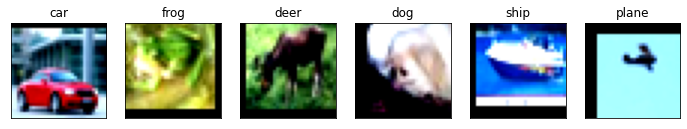

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def convert_to_imshow_format(image):
    # first convert back to [0,1] range from [-1,1] range
    image = image / 2 + 0.5
    image = image.numpy()
    # convert from CHW to HWC
    # from 3x32x32 to 32x32x3
    return image.transpose(1,2,0)

temp_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)

dataiter = iter(temp_loader)
images, labels = dataiter.next()

images = images[:6]
labels = labels[:6]

fig, axes = plt.subplots(1, len(images), figsize=(12,2.5))
for idx, image in enumerate(images):
    axes[idx].imshow(convert_to_imshow_format(image))
    axes[idx].set_title(classes[labels[idx]])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

### Specify a model architecture
---


In [7]:
# [ conv_layers 변경 예 1 ]

# self.conv_layers = nn.Sequential(
    
#     nn.Conv2d( in_channels=3, out_channels=32, kernel_size=3, padding=1 ), # 3, 32x32 -> 32, 32x32
#     nn.BatchNorm2d(32),
#     nn.ReLU(),
#     nn.MaxPool2d(2), # 32, 32x32 -> 32, 16x16

#     nn.Conv2d( in_channels=32, out_channels=64, kernel_size=3, padding=1 ), # 32, 16x16 -> 64, 16x16
#     nn.BatchNorm2d(64),
#     nn.ReLU(),
#     nn.MaxPool2d(2), # 64, 16x16 -> 64, 8x8

# }


In [8]:
# SimpleCNN의 구조를 변경
class SimpleCNN(nn.Module):

    def __init__(self, num_classes=10):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3,64,kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64,64,kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64,128,kernel_size=3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(128,128,kernel_size=3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128,256,kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Conv2d(256,256,kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Conv2d(256,256,kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Conv2d(256,256,kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fc = nn.Sequential(
           nn.Dropout(),
           nn.Linear(512,512),
           nn.ReLU(True),
           nn.Dropout(),
           nn.Linear(512,512),
           nn.ReLU(True),
           nn.Linear(512,10),
        )


    def forward(self, x):
        out = self.conv(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

### Hyperparameters
---


In [9]:
batch_size = 256
learning_rate = 0.1
num_epochs = 200

### Setup the data loaders
---


In [10]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4)



### Instantiate the model
---

In [11]:
model = SimpleCNN()

model.to(device)


SimpleCNN(
  (conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 2

### Train the model
---

In [12]:
# 변경 원하는 경우 변경 가능

criterion = nn.CrossEntropyLoss()

# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

In [13]:
from statistics import mean 

def train(optimizer, model, num_epochs=10, first_epoch=1):
    
    criterion = nn.CrossEntropyLoss()

    train_losses = []
    test_losses = []

    for epoch in range(first_epoch, first_epoch + num_epochs):
        print('Epoch', epoch)

        # train phase
        model.train()

        # create a progress bar
        progress = ProgressMonitor(length=len(train_set))
        
        # keep track of predictions
        correct_train = 0

        batch_losses = []

        for batch, targets in train_loader:
            
            # Move the training data to the GPU
            batch = batch.to(device)
            targets = targets.to(device)

            # clear previous gradient computation
            optimizer.zero_grad()

            # forward propagation
            outputs = model(batch)

            # calculate the loss
            loss = criterion(outputs, targets)

            # backpropagate to compute gradients
            loss.backward()

            # update model weights
            optimizer.step()

            batch_losses.append(loss.item())

            # accumulate correct count
            _, preds = torch.max(outputs, 1)
            correct_train += torch.sum(preds == targets.data)

            # update progress bar
            progress.update(batch.shape[0], mean(batch_losses) )
            
        
        train_losses.append( mean(batch_losses))


        # test phase
        model.eval()

        y_pred = []

        correct_test = 0

        # We don't need gradients for test, so wrap in 
        # no_grad to save memory
        with torch.no_grad():

            for batch, targets in test_loader:

                # Move the training batch to the GPU
                batch = batch.to(device)
                targets = targets.to(device)

                # forward propagation
                outputs = model(batch)

                # calculate the loss
                loss = criterion(outputs, targets)

                # save predictions
                y_pred.extend( outputs.argmax(dim=1).cpu().numpy() )

                # accumulate correct count
                _, preds = torch.max(outputs, 1)
                correct_test += torch.sum(preds == targets.data)
                

        # Calculate accuracy
        train_acc = correct_train.item() / train_set.data.shape[0]
        test_acc = correct_test.item() / test_set.data.shape[0]

        print('Training accuracy: {:.2f}%'.format(float(train_acc) * 100))
        print('Test accuracy: {:.2f}%\n'.format(float(test_acc) * 100))

    
    return train_losses, test_losses, y_pred

### Checkpointing
---

In [ ]:
train_losses, test_losses, y_pred = train(optimizer, model, num_epochs=num_epochs)

Epoch 1


Loss: 1.9644 50000 / 50000,50000


Training accuracy: 21.31%
Test accuracy: 23.97%

Epoch 2


Loss: 1.7786 50000 / 50000,50000


Training accuracy: 29.78%
Test accuracy: 29.24%

Epoch 3


Loss: 1.6033 50000 / 50000,50000


Training accuracy: 36.10%
Test accuracy: 36.96%

Epoch 4


Loss: 1.3860 50000 / 50000,50000


Training accuracy: 45.77%
Test accuracy: 45.76%

Epoch 5


Loss: 1.2213 50000 / 50000,50000


Training accuracy: 55.72%
Test accuracy: 55.93%

Epoch 6


Loss: 1.0577 50000 / 50000,50000


Training accuracy: 63.05%
Test accuracy: 65.08%

Epoch 7


Loss: 0.9378 50000 / 50000,50000


Training accuracy: 67.93%
Test accuracy: 64.39%

Epoch 8


Loss: 0.8424 50000 / 50000,50000


Training accuracy: 72.48%
Test accuracy: 55.31%

Epoch 9


Loss: 0.7669 50000 / 50000,50000


Training accuracy: 75.34%
Test accuracy: 74.91%

Epoch 10


Loss: 0.7260 50000 / 50000,50000


Training accuracy: 77.15%
Test accuracy: 73.42%

Epoch 11


Loss: 0.6808 50000 / 50000,50000


Training accuracy: 78.75%
Test accuracy: 75.59%

Epoch 12


Loss: 0.6529 50000 / 50000,50000


Training accuracy: 79.54%
Test accuracy: 74.21%

Epoch 13


Loss: 0.6113 50000 / 50000,50000


Training accuracy: 81.01%
Test accuracy: 71.98%

Epoch 14


Loss: 0.5950 50000 / 50000,50000


Training accuracy: 81.50%
Test accuracy: 75.27%

Epoch 15


Loss: 0.5645 50000 / 50000,50000


Training accuracy: 82.37%
Test accuracy: 77.43%

Epoch 16


Loss: 0.5650 50000 / 50000,50000


Training accuracy: 82.65%
Test accuracy: 77.46%

Epoch 17


Loss: 0.5474 50000 / 50000,50000


Training accuracy: 83.08%
Test accuracy: 73.11%

Epoch 18


Loss: 0.5250 50000 / 50000,50000


Training accuracy: 83.74%
Test accuracy: 75.49%

Epoch 19


Loss: 0.5195 50000 / 50000,50000


Training accuracy: 84.07%
Test accuracy: 81.57%

Epoch 20


Loss: 0.5158 50000 / 50000,50000


Training accuracy: 84.27%
Test accuracy: 76.03%

Epoch 21


Loss: 0.4998 50000 / 50000,50000


Training accuracy: 84.68%
Test accuracy: 81.88%

Epoch 22


Loss: 0.4912 50000 / 50000,50000


Training accuracy: 85.03%
Test accuracy: 75.97%

Epoch 23


Loss: 0.4803 50000 / 50000,50000


Training accuracy: 85.23%
Test accuracy: 81.62%

Epoch 24


Loss: 0.4598 50000 / 50000,50000


Training accuracy: 85.75%
Test accuracy: 78.11%

Epoch 25


Loss: 0.4511 50000 / 50000,50000


Training accuracy: 86.16%
Test accuracy: 78.27%

Epoch 26


Loss: 0.4508 50000 / 50000,50000


Training accuracy: 86.13%
Test accuracy: 60.71%

Epoch 27


Loss: 0.4418 50000 / 50000,50000


Training accuracy: 86.31%
Test accuracy: 80.79%

Epoch 28


Loss: 0.4240 50000 / 50000,50000


Training accuracy: 86.95%
Test accuracy: 71.59%

Epoch 29


Loss: 0.4248 50000 / 50000,50000


Training accuracy: 87.00%
Test accuracy: 84.09%

Epoch 30


Loss: 0.4208 50000 / 50000,50000


Training accuracy: 87.00%
Test accuracy: 81.00%

Epoch 31


Loss: 0.4142 50000 / 50000,50000


Training accuracy: 87.38%
Test accuracy: 83.43%

Epoch 32


Loss: 0.4207 50000 / 50000,50000


Training accuracy: 87.19%
Test accuracy: 80.02%

Epoch 33


Loss: 0.3947 50000 / 50000,50000


Training accuracy: 87.82%
Test accuracy: 82.14%

Epoch 34


Loss: 0.4047 50000 / 50000,50000


Training accuracy: 87.49%
Test accuracy: 79.46%

Epoch 35


Loss: 0.3989 50000 / 50000,50000


Training accuracy: 87.82%
Test accuracy: 75.48%

Epoch 36


Loss: 0.4001 50000 / 50000,50000


Training accuracy: 87.64%
Test accuracy: 78.15%

Epoch 37


Loss: 0.3903 50000 / 50000,50000


Training accuracy: 87.94%
Test accuracy: 80.72%

Epoch 38


Loss: 0.3987 50000 / 50000,50000


Training accuracy: 87.73%
Test accuracy: 82.96%

Epoch 39


Loss: 0.3832 50000 / 50000,50000


Training accuracy: 88.41%
Test accuracy: 81.19%

Epoch 40


Loss: 0.3825 50000 / 50000,50000


Training accuracy: 88.41%
Test accuracy: 76.75%

Epoch 41


Loss: 0.3736 50000 / 50000,50000


Training accuracy: 88.47%
Test accuracy: 83.06%

Epoch 42


Loss: 0.3849 50000 / 50000,50000


Training accuracy: 88.00%
Test accuracy: 79.88%

Epoch 43


Loss: 0.3738 2048 / 50000,2048


In [ ]:
# learning rate 0.01
learning_rate = 0.01
num_epochs = 30
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_losses, test_losses, y_pred = train(optimizer, model, num_epochs=num_epochs)

In [ ]:
# learning rate 0.001
learning_rate = 0.001
num_epochs = 30
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_losses, test_losses, y_pred = train(optimizer, model, num_epochs=num_epochs)

### Make a CSV for submission
---

In [ ]:

# test phase
model.eval()

# keep track of predictions
y_pred = []

# We don't need gradients for test, so wrap in 
# no_grad to save memory
with torch.no_grad():

    for batch, targets in test_loader:

        # Move the training batch to the GPU
        batch = batch.to(device)
        targets = targets.to(device)

        # forward propagation
        predictions = model(batch)

        # save predictions
        y_pred.extend( predictions.argmax(dim=1).cpu().numpy() )



In [ ]:
import csv

def make_pred_csv(model):
    with open('cifar10_submit.csv', mode='w') as pred_file:
    
        pred_writer = csv.writer(pred_file, delimiter=',')
        pred_writer.writerow(['id', 'label'])

        for i, label in enumerate(y_pred):
            pred_writer.writerow([i+1, classes[label]])
    

make_pred_csv(model)

## Kaggle에 제출 방법

---

#### 1) CSV Download

---


- 위의 Make a CSV for submission 항목의 코드들을 실행
- 왼쪽의 폴더 버튼을 클릭한 후 나오는 Files 패널에서 **cifar10_submit.csv** 확인
- 보이지 않을 경우 Refresh 클릭
- **cifar10_submit.csv** 오른쪽 클릭하여 다운로드


---

<img src="https://ycs-class.s3.ap-northeast-2.amazonaws.com/images/csv_download.png" width="400">


#### 2) Kaggle에 제출

---

- 연세계정 혹은 구글계정으로 https://www.kaggle.com 에 register 혹은 login.

- Kaggle 02분반 제출 링크로 이동: https://www.kaggle.com/t/dc2ed4437fdc4d2aa84da7de8d58f8eb

- Team 탭을 클릭하여 먼저 이름을 이름 + 학번으로 변경

- 다운로드 했던 csv 파일을 제출

---

<img src="https://ycs-class.s3.ap-northeast-2.amazonaws.com/images/IMG_46D72CB4A21A-1.jpeg" width="1000">
